In [36]:
%matplotlib inline

In [37]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as Data
from torch.utils.data import TensorDataset, IterableDataset, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as optim
#from torch.autograd import Variable

import torchvision
from torchvision import transforms

In [38]:
from chiffresManuscrits_apprentissage import plot_confusion_matrix
from chiffresManuscrits_apprentissage import get_accuracy
from chiffresManuscrits_apprentissage import affichageDesPerformancesDuReseau

# Utilisation d’un Réseau convolutif pour la classification de Chiffres Manuscrits
# Notion de masques et de poids partagés
***
Tout ce qui suit est copié de tutoriaux pytorch : [pytorch]().

In [39]:
# Hyper parameteres
n_epoch = 10        # nombre de passage des donnees d'apprentissage
# aining data n times, to save time, we just train 1 epoch
BATCH_SIZE = 20  
LR = 0.001       # learning rate

## Jeux d'apprentissage

Comme précédemment on charge les données et on partionne nos ensembles d'apprentissage, validation et test.

In [5]:
class MonDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        if len(targets.shape) == 1:
            targets = targets[:,None]
        self.targets = targets
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index,:,:].reshape((1,self.data.shape[1],self.data.shape[2]))
        label = self.targets[index, 0]
        if self.transform is not None:
            image = self.transform(image)            
        return image, label

### Chargement des fichiers de données

In [6]:
# les différents type de donnees
x = np.loadtxt("x.txt") ; 
hx = np.loadtxt("hx.txt") ; hx_hy = np.loadtxt("hx_hy.txt")
pb_ph = np.loadtxt("pb_ph.txt") ; pg_pd = np.loadtxt("pg_pd.txt")
hx_hy_pb_ph = np.loadtxt("hx_hy_pb_ph.txt") ; hx_hy_pg_pd = np.loadtxt("hx_hy_pg_pd.txt")

#### On veut des images
On a vu que l'o npouvait représenter les chiffres avec différents types de codages.    
Ici, on va travailler avec les images originale.    
Pour l'instant, on a bien des images mais elles sont stockées sous la forme de vecteurs.    
On va donc les mettre en forme.

##### Les entrées du réseau (images des chiffres)

In [7]:
X = x.T
del x, hx, hx_hy, pb_ph, pg_pd, hx_hy_pb_ph, hx_hy_pg_pd

In [8]:
nombreDImages=X.shape[0]
tailleImage= int(np.sqrt(X.shape[1]))
X = np.reshape(X,(nombreDImages,tailleImage,tailleImage),order='C')

In [9]:
print('dimensions de X :',X.shape)
print(f"On a donc {nombreDImages} images "
      + f"de taille {tailleImage}x{tailleImage}.")

dimensions de X : (480, 16, 16)
On a donc 480 images de taille 16x16.


##### Les sorties du réseau (valeurs des chiffres associés aux images)

In [10]:
# sortie
t = np.loadtxt("t.txt").astype(int).T
t[np.where(t==-1)] = 0
t_label_num = np.where(t==1)[1]
class_label = ['zero','un','deux','trois','quatre','cinq','six','sept','huit','neuf']
#classes = ['zero','un','deux','trois','quatre','cinq','six','sept','huit','neuf']
t_label_str = [ class_label[i] for i in t_label_num]
if False:
    T = t
else:
    T = t_label_num
del t, t_label_num

##### Affichage des entrées et des sorties
Comme on traite des images, on va les regarder.    
(En cas de mauvaise performance, on pourra regarder les données mal classées pour essayer de comprendre.)

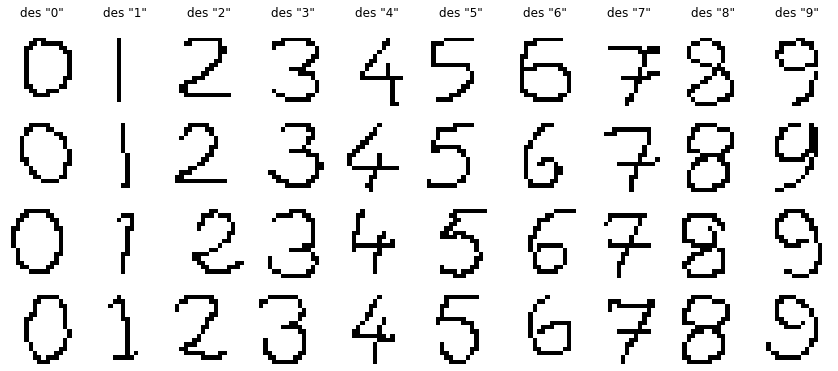

In [11]:
gs1 = gridspec.GridSpec(4, 10)
gs1.update(wspace=0.025, hspace=0.25) # set the spacing between axes. 

plt.figure(figsize=(10+5,4+2))
for i in range(min(40,nombreDImages)):
    plt.subplot(gs1[i])
    plt.imshow(X[i,:,:].squeeze(),cmap='binary')
    plt.axis('off')
    if i < 10:
        plt.gca().set_title('des "{}"\n'.format(T[i]))
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.gca().set_aspect('equal')
#plt.tight_layout()

##### Que cherche-t-on à faire ?
Ici, on va utiliser un réseau convolutionnel pour déterminer la valeur d'un nombre à partir de son image. 
Le réseau devra estimer des paramètres pour pouvoir apprendre les sorties connaissant les entrées.    
Contrairement à ce qui a été fait précédemment on travaille ici sur l'architecture du réseau et non sur le codage des entrées.    
Ici on ne va pas réduire la dimension des entrées en concentrant l'information dans un nombre réduit de variables.         
Le réseau va prendre en compte le fait que les pixels ne sont pas indépendants.    
Cela va se faire au niveau du choix de l'architecture. 

In [12]:
# les différentes classes attendues dans la suite
classes = np.unique(T)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Réalisation des ensembles d'apprentissage

In [13]:
if X.shape[0] == T.shape[0]:
    if len(T.shape) == 1:
        N_output = 1
    else:
        N_output = T.shape[1]
    N_input  = X.shape[1]
    nombreDeDonnees = X.shape[0]
else:
    raise ErrorValue('nombre de données incoherentes')

In [14]:
train_all, test, train_all_label, test_label = train_test_split(X, T, test_size=0.2)
train, validation, train_label, validation_label = train_test_split(train_all, train_all_label, test_size=0.2)

#### Réalisation des tenseurs (et chargeur de données)

In [15]:
train_all_data = torch.as_tensor(train_all).type(torch.FloatTensor)
train_all_label_tensor = torch.as_tensor(train_all_label)

In [16]:
train = torch.as_tensor(train).type(torch.FloatTensor)
train_label = torch.as_tensor(train_label)
train_data = MonDataset(train,train_label)
#train_data = IterableDataset(train,train_label) # learning dataset

In [17]:
print('train_data :')
print('  type : ',type(train_data))
print('  taille des entrees :',train_data.data.size())   # (307, 16, 16)
print('  taille des sorties :',train_data.targets.size())# (307,1)

train_data :
  type :  <class '__main__.MonDataset'>
  taille des entrees : torch.Size([307, 16, 16])
  taille des sorties : torch.Size([307, 1])


In [18]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 16, 16)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
# Pour voir à quoi cela ressemble
if False: # True: # 
    for step, (b_x, b_y) in enumerate(train_loader):
        print(b_x.size(), b_y.size())

In [20]:
validation = torch.as_tensor(validation).type(torch.FloatTensor)
validation_label = torch.as_tensor(validation_label)
#validation_data = TensorDataset(validation,validation_label) # validation dataset
validation_data = MonDataset(validation,validation_label)

In [21]:
print('validation_data :')
print('  type : ',type(validation_data))
print('  taille des entrees :',validation_data.data.size())   # (77, 16, 16)
print('  taille des sorties :',validation_data.targets.size())# (77)

validation_data :
  type :  <class '__main__.MonDataset'>
  taille des entrees : torch.Size([77, 16, 16])
  taille des sorties : torch.Size([77, 1])


In [22]:
test = torch.as_tensor(test).type(torch.FloatTensor)
test_label = torch.as_tensor(test_label)
#test_data = TensorDataset(test,test_label) # test dataset
test_data = MonDataset(test,test_label)

In [23]:
print('test_data :')
print('  type : ',type(test_data))
print('  taille des entrees :',test_data.data.size())   # (96, 16, 16)
print('  taille des sorties :',test_data.targets.size())# (96)

test_data :
  type :  <class '__main__.MonDataset'>
  taille des entrees : torch.Size([96, 16, 16])
  taille des sorties : torch.Size([96, 1])


### Afficher les images contenues dans les iterateurs

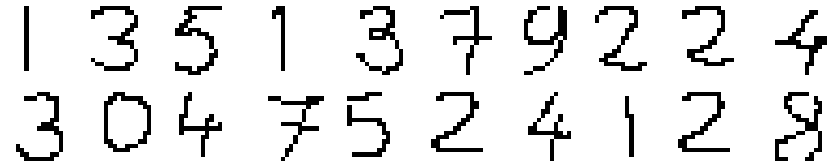

In [24]:
if True:
    gs1 = gridspec.GridSpec(4, 10)
    gs1.update(wspace=0.025, hspace=0.25) # set the spacing between axes. 

    dataiter = iter(train_loader)
    plt.figure(figsize=(10+5,4+2))
    images, targets = dataiter.next()
    for i in range(min(40,BATCH_SIZE)):
        plt.subplot(gs1[i])
        #imshow(torchvision.utils.make_grid(images))#,cmap='binary')
        plt.imshow(images[i,:,:].numpy().squeeze(),cmap='binary')
        plt.axis('off')
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
    #plt.tight_layout()

Ici, on a des entrées de taille 16x16 (et non de taille 28x28 pour MNIST ou de 32x32 pour le réseau LeNet).    
Remarque: Si on voulait travailler avec les données de MNIST ou celles utilisées pour le réseau LeNet. Si vous vouliez travailler avec d'autres jeux de données, il faudra faire attention à cet aspect.

## Réalisation d'un réseau de neurones 

## Réalisation d'un réseau de neurones convolutif

### 1. Définition d'un modèle d'architecture

On va construire un réseau de neurone à l'aide de la bibliothèque `torch`.
(Le module ` torch.nn` que nous utilisons pour construire notre réseau se repose sur `autograd` qui permettra de définir des modèles et à les différentier.
Un réseau est constitué de couche i.e. déléments de type `nn.Conv2d` ou `nn.Linear`. 
Il est aussi caractérisé par une méthode `forward` qui permet de calculer les sorties (`output`) pour des entrées `input`

In [25]:
#?nn.Conv2d
#?nn.Linear

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 16, 16)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 16, 16) = (out_channels, dim1Image,dim2image)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 8, 8)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 8, 8) = = (out_channels, dim1Image/2,dim2image/2)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 8, 8)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 4, 4) = (out_channels, dim1Image/4,dim2image/4)
        )
        self.out = nn.Linear(32 * 4 * 4, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization



In [27]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=512, out_features=10, bias=True)
)


##### Pour avoir des résulats reproductibles

In [28]:
torch.manual_seed(0) # set seed to make results reproducible

### 2. Définition d'une fonction de coût et d'un optimiseur
Ici, on utilise l'entropie croisée comme coût de classification ainsi qu'un optimiseur de type descente de gradient stochastique avec moment.

In [29]:
# optimize all cnn parameters
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   
# the target label is not one-hotted
loss_func = nn.CrossEntropyLoss()                       

## Apprentissage

Pour apprendre le réseau, on boucle sur notre jeu de données pour optimiser le réseau.

In [30]:
train_iter = iter(train_loader)
print(type(train_iter))
b_x,b_y = train_iter.next()
print(b_x.size(), b_y.size())

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
torch.Size([20, 1, 16, 16]) torch.Size([20])


In [31]:
train_data_ = torch.unsqueeze(train_data.data, dim=1).type(torch.FloatTensor)[:]
train_targets_ = train_data.targets[:]
validation_data_ = torch.unsqueeze(validation_data.data, dim=1).type(torch.FloatTensor)[:]
validation_targets_ = validation_data.targets[:]
test_data_ = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:]
test_targets_ = test_data.targets[:]

In [32]:
test_data.data.shape

torch.Size([96, 16, 16])

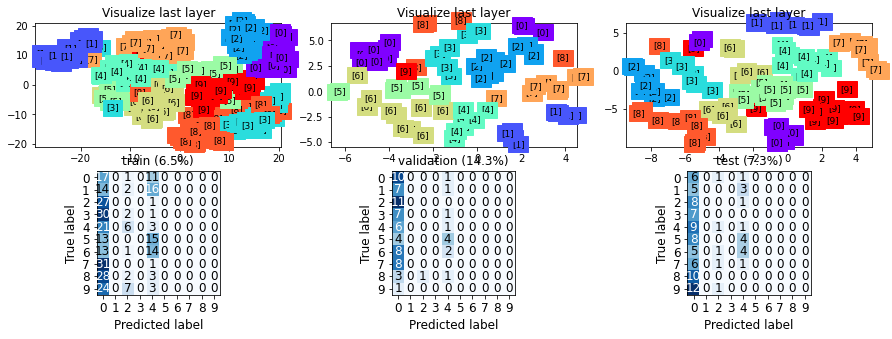

In [33]:
affichageDesPerformancesDuReseau(cnn, classes, 
                                 train_data_, train_targets_,
                                 validation_data_,validation_targets_,
                                 test_data_,test_targets_)

Epoch:  0 | train loss: 2.3141 | validation accuracy: 22.08


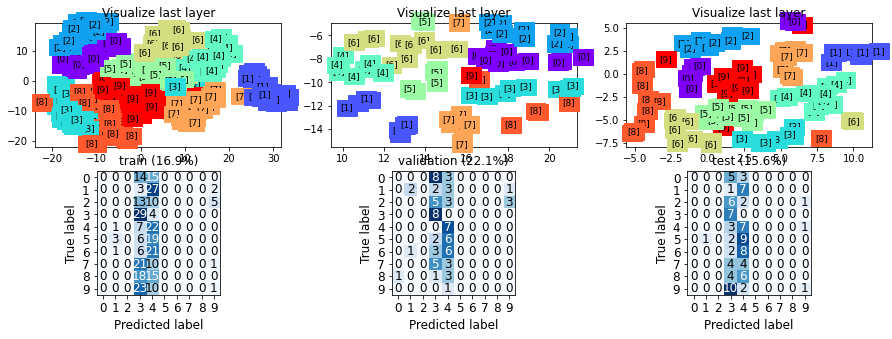

Epoch:  1 | train loss: 1.9861 | validation accuracy: 72.73


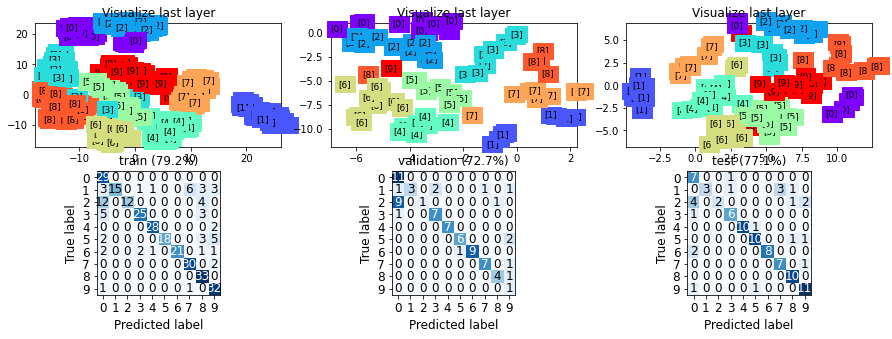

Epoch:  2 | train loss: 1.2214 | validation accuracy: 87.01


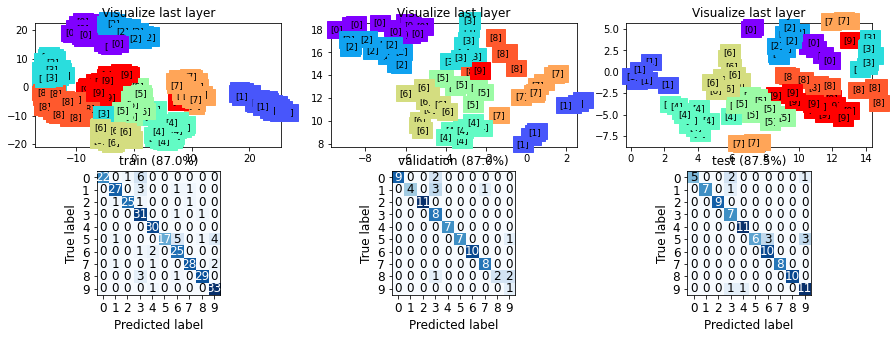

Epoch:  3 | train loss: 0.6085 | validation accuracy: 90.91


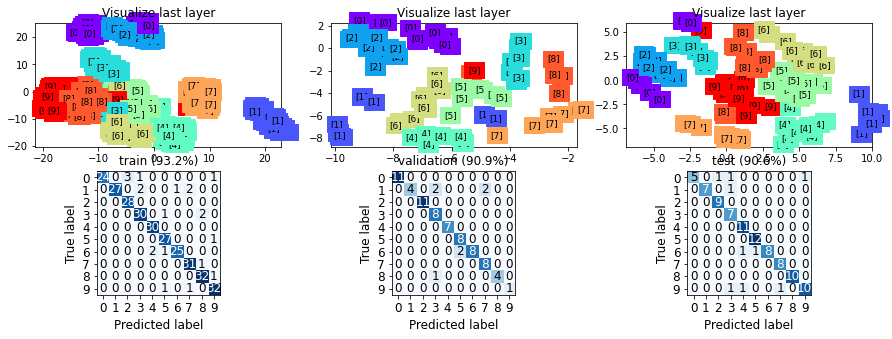

Epoch:  4 | train loss: 0.4404 | validation accuracy: 93.51


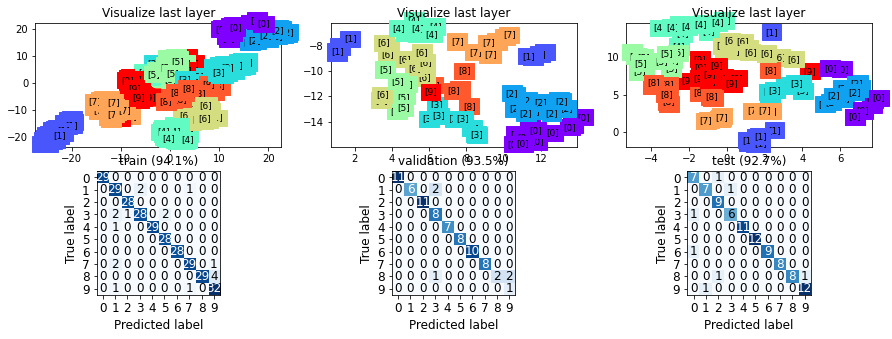

Epoch:  5 | train loss: 0.1120 | validation accuracy: 92.21


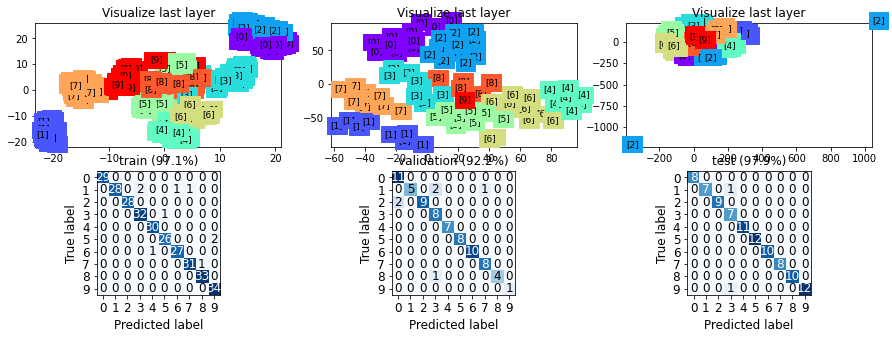

Epoch:  6 | train loss: 0.1381 | validation accuracy: 100.00


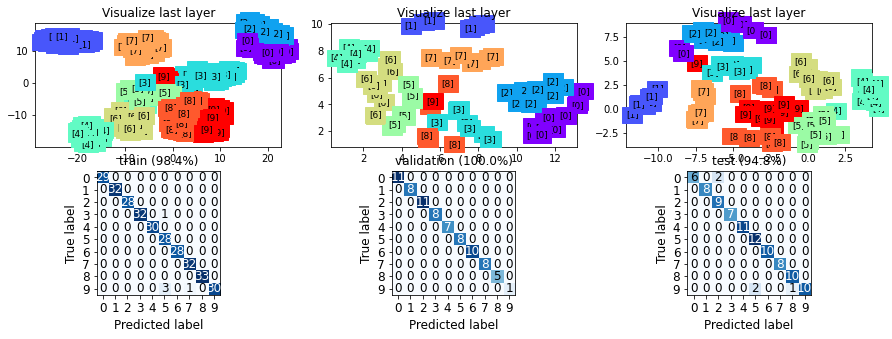

Epoch:  7 | train loss: 0.0985 | validation accuracy: 100.00


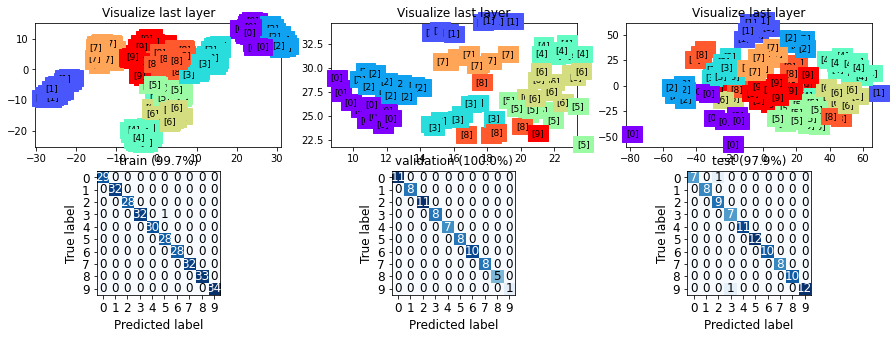

Epoch:  8 | train loss: 0.0452 | validation accuracy: 100.00


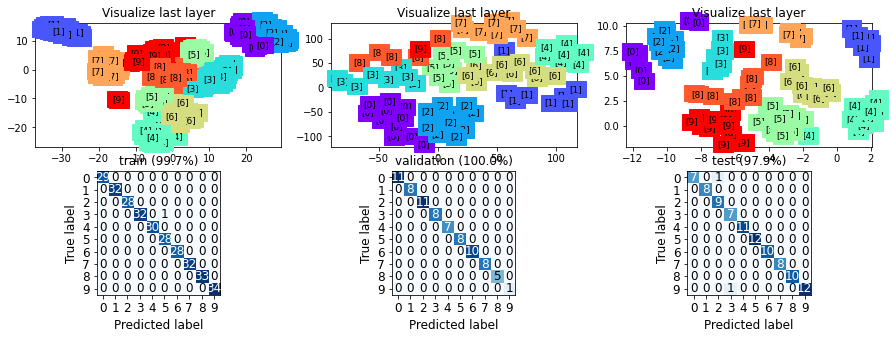

Epoch:  9 | train loss: 0.0339 | validation accuracy: 100.00


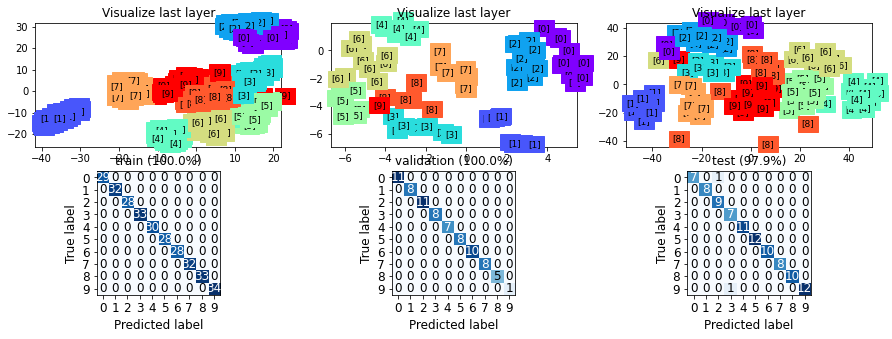

In [34]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
plt.ion()
# training and testing
for epoch in range(n_epoch):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        #print(b_x.size(), b_y.size())
        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            print('Epoch: ', epoch, '|','train loss: %.4f' % loss.data.numpy(),end=' ')
            #train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            validation_output_, last_layer = cnn(validation_data_)
            validation_predictions_ = torch.max(validation_output_, 1)[1].data.numpy()
            accuracy = get_accuracy(validation_predictions_,validation_targets_)
            #accuracy = float((validation_predictions_ == validation_targets_.data.numpy()).astype(int).sum()) / float(validation_targets_.size(0))
            print( '| validation accuracy: %.2f' % accuracy)
            affichageDesPerformancesDuReseau(cnn, classes,
                                     train_data_, train_targets_,
                                     validation_data_,validation_targets_,
                                     test_data_,test_targets_)
            plt.show()
plt.ioff()

Performances du réseau appris : 
Epoch:  9 | train loss: 0.0207 | test accuracy: 100.00


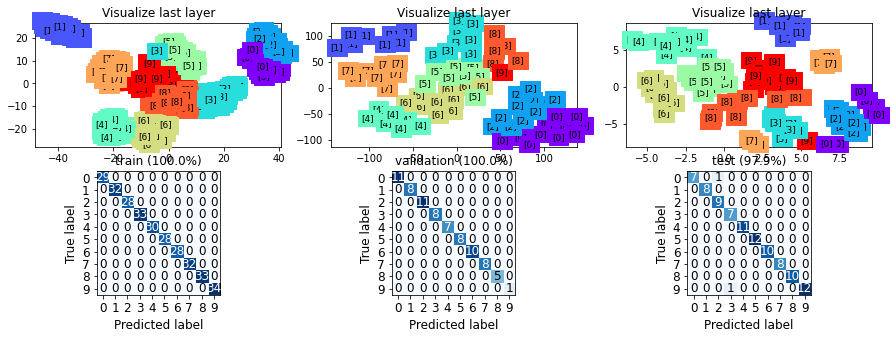

In [35]:
print('Performances du réseau appris : ')
print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            
affichageDesPerformancesDuReseau(cnn, classes,
                                     train_data_, train_targets_,
                                     validation_data_,validation_targets_,
                                     test_data_,test_targets_)

#### Comment passer des sorties du réseau à la valeur prédite
Ici, on présente les sorties du réseau.    
On en déduit la classe la plus probable qui correspond à la clase prédite.    
C'est cette valeur qui sera comparée avec la valeur cible attendue.

In [36]:
validation_output_, _ = cnn(validation_data_)
validation_predictions_ = torch.max(validation_output_, 1)[1].data.numpy()

sortiesEtAutres = np.hstack((validation_output_.detach().numpy(),validation_predictions_[:,None],validation_targets_.numpy()))
columns = ['p($C_'+str(i)+'$)' for i in range(validation_output_.shape[1])]
columns.extend(['prédite','vrai'])
pd.DataFrame(sortiesEtAutres,columns=columns)

,p($C_0$),p($C_1$),p($C_2$),p($C_3$),p($C_4$),p($C_5$),p($C_6$),p($C_7$),p($C_8$),p($C_9$),prédite,vrai
0,-8.804296,-4.164446,-2.724047,-3.614959,-4.804307,-8.923213,-10.586378,6.798340,-5.095984,-0.048659,7.0,7.0
1,-0.839683,-9.102514,3.945439,-5.238836,-9.439059,-12.432638,-4.712398,-2.184120,-4.734168,-4.117002,2.0,2.0
2,3.708862,-12.527439,-5.024364,-3.807666,-13.527736,-3.007739,-2.334020,-10.486353,-5.190544,-1.529917,0.0,0.0
3,-3.903163,-11.156404,3.702993,-3.910590,-9.727276,-12.391455,-4.439462,-3.811676,-2.281345,-4.960639,2.0,2.0
4,-5.939906,-6.302455,-10.734217,-3.297349,-6.315830,4.212150,-2.365878,-7.975509,-4.652434,-1.758303,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72,-5.451109,-5.979311,-2.787582,4.008609,-10.868214,-6.736615,-6.647682,-2.540378,-4.027574,-2.608065,3.0,3.0
73,-4.311583,-3.629708,-4.895254,-2.577295,-5.299056,-4.935645,-6.239060,1.484014,-7.129182,-2.268457,7.0,7.0
74,-4.654616,-11.511642,-7.215909,-5.975595,-2.235780,-3.586923,2.906270,-9.376056,-3.483520,-4.388247,6.0,6.0
75,-4.163342,-11.729006,-8.138094,-2.442178,-8.033724,-0.824484,-1.784034,-7.578954,-2.632004,-2.439452,5.0,5.0


Let's quickly save our trained model:

In [37]:
PATH = './monMnist_net.pth'
torch.save(cnn.state_dict(), PATH)

On recharge le réseau.

In [38]:
#cnn = CNN()
#net.load_state_dict(torch.load(PATH))

Ici, on a travaillé avec un jeu de données réduit.    
Si on avait un peu plus de temps, on aurait travaillé avec le jeu de données MNIST original.    
Ici, on n'ira pas jusqu'au bout de la démarche si vous le souhaitez vous pourrez aller voir 
comment on construit et on apprend un réseau convolutif :    
[Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) [(le notebook associé)](https://pytorch.org/tutorials/_downloads/97abb4c06a586d45ef3fc4b4b9634406/neural_networks_tutorial.ipynb)    
[Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=torch%20vision%20mnist) [(le notebook associé)](https://pytorch.org/tutorials/_downloads/17a7c7cb80916fcdf921097825a0f562/cifar10_tutorial.ipynb)
         
         
![convnet](mnist.png 'convnet')

It is a simple feed-forward network. It takes the input, feeds it
through several layers one after the other, and then finally gives the
output.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``